Imports

In [1]:
# Standard library imports
import os
import re
import unicodedata
import warnings

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import textstat
from textblob import TextBlob
from textblob_nl import PatternAnalyzer
from tqdm.notebook import tqdm
import requests


### Carsales

extracted from https://opendata.cbs.nl/#/CBS/nl/dataset/85898NED/table?ts=1745764299955

>Dataset inladen 

In [40]:
# Autoverkoop inladen
df_wegvoertuigenRaw = pd.read_csv(
    r"E:\Nieuw dataset\Verkochte wegvoertuigen\Verkochte_wegvoertuigen_Full elektric.csv",
    sep=";"
)

display(df_wegvoertuigenRaw)

,Wegvoertuigen,Brandstofsoort voertuig,Perioden,Totaal verkochte wegvoertuigen (aantal)
0,Totaal wegvoertuigen,Full elektric (BEV),2007 januari,31
1,Totaal wegvoertuigen,Full elektric (BEV),2007 februari,39
2,Totaal wegvoertuigen,Full elektric (BEV),2007 maart,123
3,Totaal wegvoertuigen,Full elektric (BEV),2007 april,62
4,Totaal wegvoertuigen,Full elektric (BEV),2007 mei,84
...,...,...,...,...
214,Totaal wegvoertuigen,Full elektric (BEV),2024 november*,32623
215,Totaal wegvoertuigen,Full elektric (BEV),2024 december*,39594
216,Totaal wegvoertuigen,Full elektric (BEV),2025 januari*,33680
217,Totaal wegvoertuigen,Full elektric (BEV),2025 februari*,29071


>Data opschonen en transformeren: Nederlandse naar Engelse maanden, periode-format, filtering, Mapping van Nederlandse naar Engelse maandnamen

In [41]:
maand_mapping = {
    'januari': 'January',
    'februari': 'February',
    'maart': 'March',
    'april': 'April',
    'mei': 'May',
    'juni': 'June',
    'juli': 'July',
    'augustus': 'August',
    'september': 'September',
    'oktober': 'October',
    'november': 'November',
    'december': 'December'
}

# 1. Sterretjes verwijderen
df_wegvoertuigenRaw['Perioden'] = df_wegvoertuigenRaw['Perioden'].str.replace('*', '', regex=False).str.strip()

# 2. Nederlandse maandnamen vervangen door Engelse
for nl, eng in maand_mapping.items():
    df_wegvoertuigenRaw['Perioden'] = df_wegvoertuigenRaw['Perioden'].str.replace(nl, eng, regex=False)

# 3. Periode omzetten naar datetime
df_wegvoertuigenRaw['Periode'] = pd.to_datetime(df_wegvoertuigenRaw['Perioden'], format='%Y %B', errors='coerce')

# 4. Omzetten naar YYYY/MM string
df_wegvoertuigenRaw['Periode'] = df_wegvoertuigenRaw['Periode'].dt.strftime('%Y/%m')

# 5. Alleen relevante kolommen behouden
df_wegvoertuigen = df_wegvoertuigenRaw[['Periode', 'Totaal verkochte wegvoertuigen (aantal)']]

# 5b. Filter op periode 2015/01 t/m 2025/03
df_wegvoertuigen = df_wegvoertuigen[
    (df_wegvoertuigen['Periode'] >= '2007/01') & 
    (df_wegvoertuigen['Periode'] <= '2025/03')
]

# 6. Kolom hernoemen
df_wegvoertuigen.rename(columns={'Totaal verkochte wegvoertuigen (aantal)': 'Totaal_verkochte_wegvoertuigen'}, inplace=True)

# 7. Resultaat bekijken
display(df_wegvoertuigen)


,Periode,Totaal_verkochte_wegvoertuigen
0,2007/01,31
1,2007/02,39
2,2007/03,123
3,2007/04,62
4,2007/05,84
...,...,...
214,2024/11,32623
215,2024/12,39594
216,2025/01,33680
217,2025/02,29071


> Opslaan als CSV

In [42]:
# Opslaan als CSV
output_path = r"E:\Nieuw dataset\Verkochte wegvoertuigen\df_wegvoertuigen_2007.csv"
df_wegvoertuigen.to_csv(output_path, index=False)

# Pad van de nieuwe CSV printen
print(f"CSV opgeslagen op: {output_path}")

CSV opgeslagen op: E:\Nieuw dataset\Verkochte wegvoertuigen\df_wegvoertuigen_2007.csv


## Google trends:

extracted from https://trends.google.com/trends/explore?cat=47&date=all&geo=NL&q=EV,subsidie%20elektrische%20auto,elektrische%20auto,elektrisch%20rijden

In [47]:
# Autoverkoop inladen
df_trends_Raw = pd.read_csv(
    r"E:\Nieuw dataset\Google trends\GoogleTrends_EV_Zoektermen_NL_2004heden.csv.",
    sep=","
)

display(df_trends_Raw)

,Maand,EV: (Nederland),subsidie elektrische auto: (Nederland),elektrische auto: (Nederland),elektrisch rijden: (Nederland)
0,2004-01,0,0,0,0
1,2004-02,0,0,0,0
2,2004-03,0,0,0,0
3,2004-04,0,0,0,0
4,2004-05,0,0,0,0
...,...,...,...,...,...
252,2025-01,45,4,47,4
253,2025-02,45,2,42,4
254,2025-03,44,2,41,4
255,2025-04,41,3,43,7


In [43]:
print(df_trends_Raw.columns)

Index(['Periode', 'EV: (Nederland)', 'subsidie elektrische auto: (Nederland)',
       'elektrische auto: (Nederland)', 'elektrisch rijden: (Nederland)'],
      dtype='object')


In [48]:


# 6. Kolom hernoemen
df_trends_Raw.rename(columns={'Maand': 'Periode'}, inplace=True)


df_trends_Raw['Periode'] = pd.to_datetime(df_trends_Raw['Periode'], format='%Y-%m', errors='coerce')
df_trends_Raw['Periode'] = df_trends_Raw['Periode'].dt.strftime('%Y/%m')



# 5b. Filter op periode 2007/01 t/m 2025/03
df_trends_Raw = df_trends_Raw[
    (df_trends_Raw['Periode'] >= '2007/01') & 
    (df_trends_Raw['Periode'] <= '2025/03') 

]
df_trends = df_trends_Raw[['Periode', 'EV: (Nederland)', 'subsidie elektrische auto: (Nederland)',
       'elektrische auto: (Nederland)', 'elektrisch rijden: (Nederland)']] 


# 7. Resultaat bekijken
display(df_trends)

,Periode,EV: (Nederland),subsidie elektrische auto: (Nederland),elektrische auto: (Nederland),elektrisch rijden: (Nederland)
36,2007/01,0,0,0,0
37,2007/02,0,0,0,0
38,2007/03,0,0,0,0
39,2007/04,0,0,0,0
40,2007/05,0,0,0,0
...,...,...,...,...,...
250,2024/11,47,14,58,4
251,2024/12,42,11,57,6
252,2025/01,45,4,47,4
253,2025/02,45,2,42,4


In [49]:
# Opslaan als CSV
output_path = r"E:\Nieuw dataset\Google trends\Trends_EV_Zoektermen_NL_2007heden.csv"
df_trends_Raw.to_csv(output_path, index=False)

# Pad van de nieuwe CSV printen
print(f"CSV opgeslagen op: {output_path}")

CSV opgeslagen op: E:\Nieuw dataset\Google trends\Trends_EV_Zoektermen_NL_2007heden.csv


### Join both datasets on periode 

In [52]:
# CSV's inladen
# Join Google Trends en Wegvoertuigen op 'Periode'
df_trends_wegvoertuigen = pd.merge(df_trends, df_wegvoertuigen, on='Periode', how='left')

# Resultaat bekijken
display(df_trends_wegvoertuigen)

# Controleer op ontbrekende waarden in de samengevoegde dataset
missing_values = df_trends_wegvoertuigen.isnull().sum()
print("Ontbrekende waarden per kolom:\n", missing_values)



,Periode,EV: (Nederland),subsidie elektrische auto: (Nederland),elektrische auto: (Nederland),elektrisch rijden: (Nederland),Totaal_verkochte_wegvoertuigen
0,2007/01,0,0,0,0,31
1,2007/02,0,0,0,0,39
2,2007/03,0,0,0,0,123
3,2007/04,0,0,0,0,62
4,2007/05,0,0,0,0,84
...,...,...,...,...,...,...
214,2024/11,47,14,58,4,32623
215,2024/12,42,11,57,6,39594
216,2025/01,45,4,47,4,33680
217,2025/02,45,2,42,4,29071


Ontbrekende waarden per kolom:
 Periode                                   0
EV: (Nederland)                           0
subsidie elektrische auto: (Nederland)    0
elektrische auto: (Nederland)             0
elektrisch rijden: (Nederland)            0
Totaal_verkochte_wegvoertuigen            0
dtype: int64


In [53]:
# Opslaan van df_trends_wegvoertuigen als CSV
output_joined_path = r"E:\Nieuw dataset\Joined trends\joined_trend_sales.csv"
df_trends_wegvoertuigen.to_csv(output_joined_path, index=False)
print(f"CSV opgeslagen op: {output_joined_path}")

CSV opgeslagen op: E:\Nieuw dataset\Joined trends\joined_trend_sales.csv


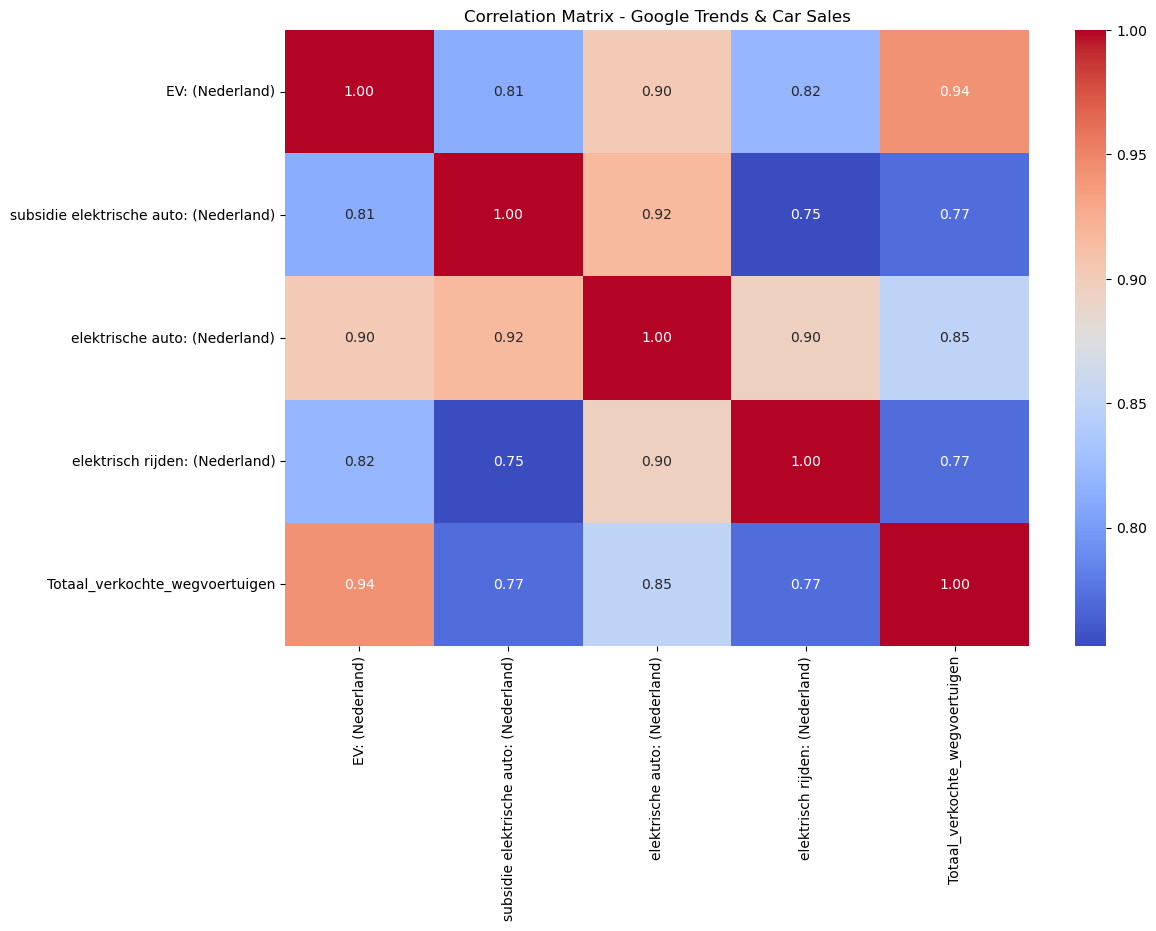

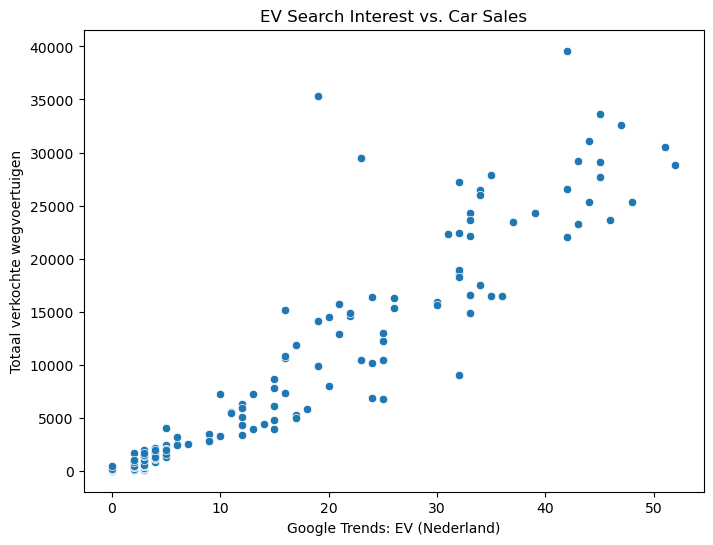

In [55]:
# Correlation matrix plot (exclude non-numeric columns)
plt.figure(figsize=(12, 8))
corr = df_trends_wegvoertuigen.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix - Google Trends & Car Sales')
plt.show()

# Scatter plot: EV search interest vs. car sales
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_trends_wegvoertuigen,
    x='EV: (Nederland)',
    y='Totaal_verkochte_wegvoertuigen'
)
plt.xlabel('Google Trends: EV (Nederland)')
plt.ylabel('Totaal verkochte wegvoertuigen')
plt.title('EV Search Interest vs. Car Sales')
plt.show()

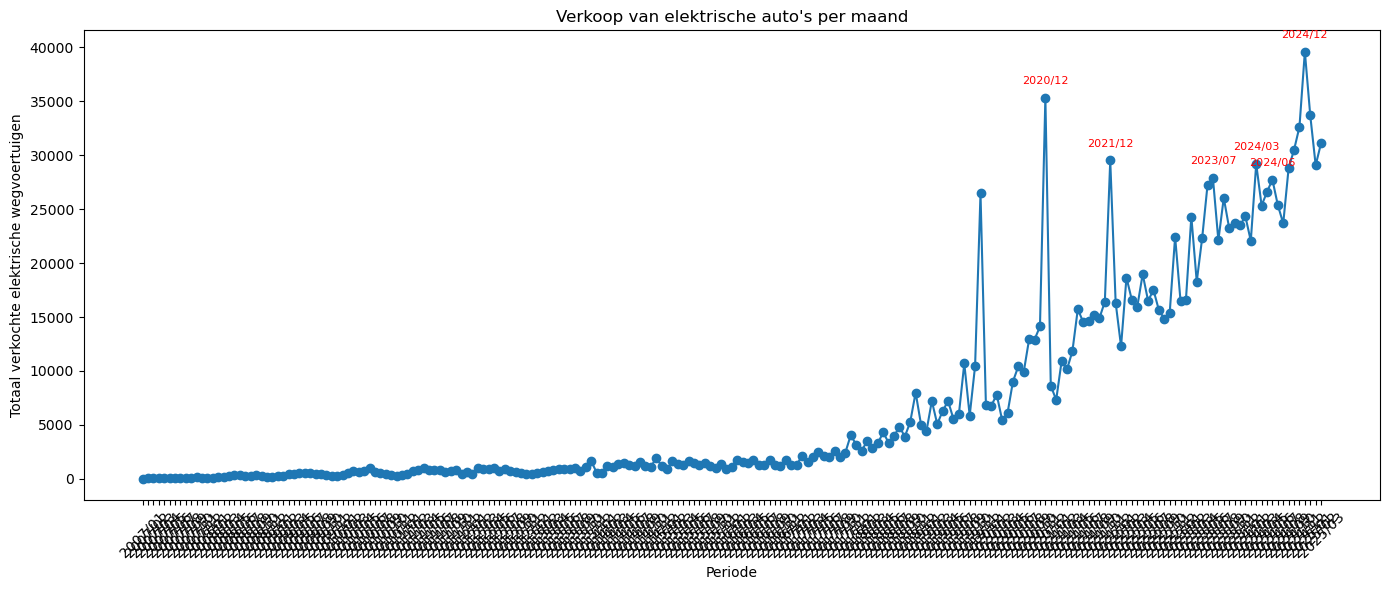

In [ ]:
from scipy.signal import find_peaks  # Import the find_peaks function for peak detection

plt.figure(figsize=(14, 6))  # Create a new figure with a specific size
plt.plot(df_wegvoertuigen['Periode'], df_wegvoertuigen['Totaal_verkochte_wegvoertuigen'], marker='o')  # Plot sales per period
plt.xlabel('Periode')  # Set x-axis label
plt.ylabel('Totaal verkochte elektrische wegvoertuigen')  # Set y-axis label
plt.title('Verkoop van elektrische auto\'s per maand')  # Set plot title
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Pieken bepalen (lokaal maximum)
peaks, _ = find_peaks(df_wegvoertuigen['Totaal_verkochte_wegvoertuigen'])  # Find indices of local maxima (peaks)

# Top 5 spikes (op basis van hoogte)
top5_idx = np.argsort(df_wegvoertuigen['Totaal_verkochte_wegvoertuigen'].iloc[peaks])[-6:]  # Get indices of 6 highest peaks
top5_peaks = peaks[top5_idx]  # Get the actual peak positions for the top 6

for peak in top5_peaks:  # Loop over each top peak
    plt.annotate(
        df_wegvoertuigen['Periode'].iloc[peak],  # Annotate with the period (month/year)
        (df_wegvoertuigen['Periode'].iloc[peak], df_wegvoertuigen['Totaal_verkochte_wegvoertuigen'].iloc[peak]),  # At the peak's coordinates
        textcoords="offset points",  # Offset the text from the point
        xytext=(0,10),  # Offset by 10 points above
        ha='center',  # Center the annotation horizontally
        fontsize=8,  # Set font size
        color='red'  # Set annotation color to red
    )
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plot